In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variables


In [34]:
num_topics = 20
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## load

In [35]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()


## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [36]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
18it [00:00, 173.10it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:05, 226.99it/s]


### tfidf

In [37]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])
vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

# find optimal k
TODO

# Clustering

In [38]:
def fit_model(model, corpus):
    model.fit(corpus)

def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, vectorizer, corpus, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i),
        vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[np.where(model.labels_ == i)])
        top_words = get_top_words(vectorizer, tfidf_corpus)
        print(top_words)
        clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters
    
model = SpectralClustering(n_clusters=num_topics)
fit_model(model, tfidf_corpus)
clusters = print_and_get_clusters(model, vectorizer, corpus)


Top terms per cluster:
Cluster 0:
('learning', 'data', 'library', 'machine', 'python', 'algorithm', 'package', 'toolbox', 'model', 'source')


Cluster 1:
('model', 'learning', 'data', 'algorithm', 'method', 'problem', 'function', 'information', 'approach', 'based')


Cluster 2:
('learning', 'bound', 'label', 'active', 'complexity', 'sample', 'rate', 'algorithm', 'problem', 'distribution')


Cluster 3:
('graph', 'learning', 'problem', 'based', 'data', 'random', 'model', 'algorithm', 'vertex', 'function')


Cluster 4:
('feature', 'selection', 'model', 'gesture', 'data', 'learning', 'sparse', 'variable', 'algorithm', 'method')


Cluster 5:
('clustering', 'algorithm', 'cluster', 'data', 'based', 'spectral', 'hierarchical', 'model', 'method', 'number')


Cluster 6:
('causal', 'effect', 'data', 'variable', 'method', 'model', 'algorithm', 'discovery', 'set', 'approach')


Cluster 7:
('tensor', 'model', 'data', 'rank', 'decomposition', 'latent', 'analysis', 'problem', 'method', 'clustering')



the words are similar to kmeans, but the composition is different

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


In [39]:
def plot(model, corpus, n_components=None):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=model.labels_, marker='x')
    plt.show()

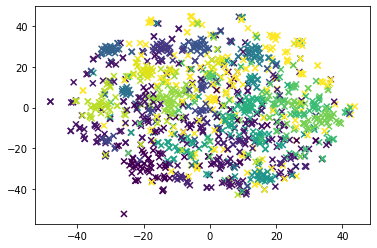

In [40]:
plot(model, tfidf_corpus)

looks like chaos

# Remove words which appear often in all clusters

In [41]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 18, 'method': 16, 'data': 15, 'model': 14, 'learning': 11, 'problem': 8, 'function': 7, 'based': 5, 'approach': 3, 'bound': 3, 'rate': 3, 'gradient': 3, 'sample': 2, 'distribution': 2, 'random': 2, 'sparse': 2, 'variable': 2, 'clustering': 2, 'cluster': 2, 'set': 2, 'rank': 2, 'matrix': 2, 'approximation': 2, 'estimator': 2, 'kernel': 2, 'regression': 2, 'optimization': 2, 'distributed': 2, 'gaussian': 2, 'high': 2, 'library': 1, 'machine': 1, 'python': 1, 'package': 1, 'toolbox': 1, 'source': 1, 'information': 1, 'label': 1, 'active': 1, 'complexity': 1, 'graph': 1, 'vertex': 1, 'feature': 1, 'selection': 1, 'gesture': 1, 'spectral': 1, 'hierarchical': 1, 'number': 1, 'causal': 1, 'effect': 1, 'discovery': 1, 'tensor': 1, 'decomposition': 1, 'latent': 1, 'analysis': 1, 'low': 1, 'completion': 1, 'density': 1, 'estimation': 1, 'robust': 1, 'mean': 1, 'policy': 1, 'iteration': 1, 'action': 1, 'loss': 1, 'class': 1, 'classifier':

most common words are similar to kmeans

In [42]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

In [43]:
corpus_new = load_data()

corpus_stopwords = preprocessing(
    corpus_new,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
22it [00:00, 217.83it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:05, 211.93it/s]


In [44]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

In [45]:
model_stopwords = SpectralClustering(n_clusters=num_topics)
fit_model(model_stopwords, tfidf_corpus_stopwords)
clusters_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, corpus_stopwords)

Top terms per cluster:
Cluster 0:
('bound', 'rate', 'sample', 'norm', 'dictionary', 'complexity', 'dimension', 'class', 'condition', 'lower')


Cluster 1:
('feature', 'selection', 'task', 'gesture', 'variable', 'sparse', 'set', 'proposed', 'based', 'recognition')


Cluster 2:
('graph', 'vertex', 'problem', 'based', 'random', 'latent', 'markov', 'set', 'nomination', 'dag')


Cluster 3:
('matrix', 'rank', 'low', 'completion', 'bound', 'problem', 'approximation', 'error', 'factorization', 'optimization')


Cluster 4:
('library', 'python', 'machine', 'toolbox', 'package', 'source', 'implementation', 'open', 'framework', 'classification')


Cluster 5:
('policy', 'iteration', 'action', 'gradient', 'based', 'function', 'td', 'search', 'value', 'space')


Cluster 6:
('loss', 'risk', 'convex', 'problem', 'function', 'optimization', 'dual', 'non', 'multiclass', 'regularization')


Cluster 7:
('stochastic', 'gradient', 'convergence', 'function', 'optimization', 'problem', 'convex', 'order', 'rate

In [46]:
terms = list(itertools.chain.from_iterable(clusters_stopwords))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'problem': 10, 'set': 7, 'function': 7, 'based': 6, 'approximation': 4, 'optimization': 4, 'distribution': 4, 'approach': 4, 'bound': 3, 'rate': 3, 'latent': 3, 'matrix': 3, 'gradient': 3, 'convex': 3, 'regression': 3, 'estimator': 3, 'class': 2, 'variable': 2, 'sparse': 2, 'graph': 2, 'random': 2, 'rank': 2, 'classification': 2, 'space': 2, 'non': 2, 'distributed': 2, 'kernel': 2, 'mean': 2, 'gaussian': 2, 'estimation': 2, 'lasso': 2, 'high': 2, 'dimensional': 2, 'inference': 2, 'analysis': 2, 'clustering': 2, 'community': 2, 'cluster': 2, 'time': 2, 'result': 2, 'sample': 1, 'norm': 1, 'dictionary': 1, 'complexity': 1, 'dimension': 1, 'condition': 1, 'lower': 1, 'feature': 1, 'selection': 1, 'task': 1, 'gesture': 1, 'proposed': 1, 'recognition': 1, 'vertex': 1, 'markov': 1, 'nomination': 1, 'dag': 1, 'low': 1, 'completion': 1, 'error': 1, 'factorization': 1, 'library': 1, 'python': 1, 'machine': 1, 'toolbox': 1, 'package': 1, 'source': 1,

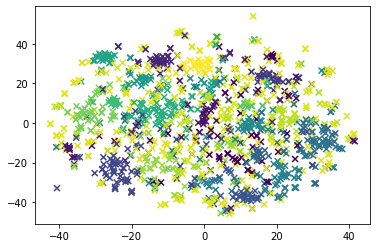

In [47]:
plot(model_stopwords, tfidf_corpus_stopwords)

Cluster looks a little bit better than before? But still not good. 

# LSA 

In [48]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

find optimal n_components

In [49]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)

def plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.plot(n, silhouettes_scores)
    ax1.set_title('silhouettes_score')
    ax2.plot(n, calinski_harabasz_scores, label="calinski_harabasz_scores")
    ax2.set_title('calinski_harabasz_scores')
    ax3.plot(n, davies_bouldin_scores, label="davies_bouldin_scores")
    ax3.set_title('davies_bouldin_scores')
    plt.show()
    

def find_n_components_lsa():
    n = [2,5,10,15,20,25,30]
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for n_component in n:
        X, svd = get_lsa_transformation(n_component, tfidf_corpus)
        model_lsa = SpectralClustering(n_clusters=num_topics)
        fit_model(model_lsa, X)
        score = list(calc_scores(tfidf_corpus, model_lsa))

        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n)

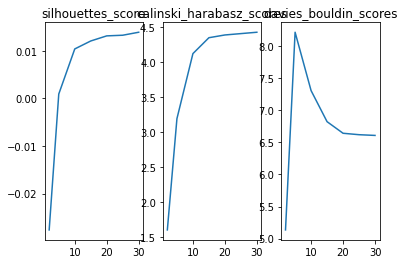

In [50]:
find_n_components_lsa()

20 seems to be good

In [51]:
n_components = 20
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = SpectralClustering(n_clusters=num_topics)
fit_model(model_lsa, X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, corpus, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('loss', 'algorithm', 'risk', 'problem', 'online', 'function', 'learning', 'data', 'method', 'regret')


Cluster 1:
('regression', 'method', 'estimator', 'model', 'high', 'data', 'algorithm', 'lasso', 'dimensional', 'estimation')


Cluster 2:
('bound', 'learning', 'rate', 'sample', 'algorithm', 'distribution', 'class', 'dimension', 'problem', 'error')


Cluster 3:
('learning', 'causal', 'data', 'algorithm', 'label', 'task', 'effect', 'problem', 'model', 'variable')


Cluster 4:
('network', 'neural', 'model', 'algorithm', 'data', 'learning', 'layer', 'deep', 'node', 'method')


Cluster 5:
('matrix', 'rank', 'low', 'bound', 'method', 'completion', 'norm', 'covariance', 'algorithm', 'data')


Cluster 6:
('model', 'data', 'graphical', 'latent', 'algorithm', 'method', 'learning', 'variable', 'selection', 'based')


Cluster 7:
('policy', 'learning', 'algorithm', 'method', 'model', 'action', 'problem', 'function', 'control', 'reinforcement')


Cluster 8:
('gr

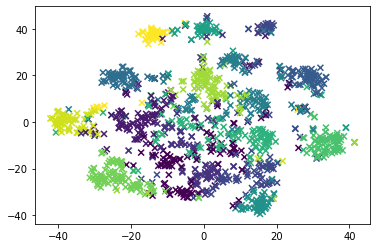

In [52]:
plot(model_lsa, X, n_components=n_components)

In [53]:
n_components = 20
X, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
model_lsa_stopwords = SpectralClustering(n_clusters=num_topics)
fit_model(model_lsa_stopwords, X)
clusters_with_lsa_stopwords = print_and_get_clusters(model_lsa_stopwords, vectorizer_stopwords, corpus_stopwords, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
('inference', 'gaussian', 'process', 'variational', 'bayesian', 'approach', 'approximation', 'distribution', 'posterior', 'latent')


Cluster 1:
('machine', 'library', 'python', 'toolbox', 'source', 'package', 'implementation', 'framework', 'classification', 'open')


Cluster 2:
('loss', 'problem', 'function', 'convex', 'optimization', 'risk', 'online', 'constraint', 'non', 'approach')


Cluster 3:
('policy', 'reinforcement', 'problem', 'function', 'agent', 'action', 'based', 'control', 'value', 'iteration')


Cluster 4:
('clustering', 'cluster', 'density', 'based', 'graph', 'estimation', 'hierarchical', 'number', 'spectral', 'matrix')


Cluster 5:
('network', 'neural', 'community', 'layer', 'node', 'deep', 'structure', 'time', 'prediction', 'problem')


Cluster 6:
('regression', 'estimator', 'high', 'dimensional', 'estimation', 'lasso', 'graphical', 'distributed', 'linear', 'approach')


Cluster 7:
('graph', 'graphical', 'problem', 'vertex', 'based', 

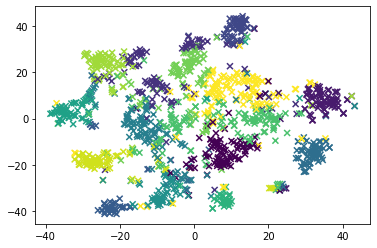

In [54]:
plot(model_lsa_stopwords, X, n_components=n_components)

# Spectral Embedding

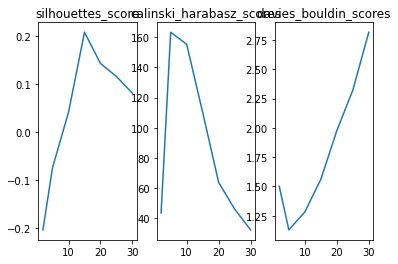

In [55]:
def find_n_components_spectral():
    n = [2,5,10,15,20,25,30]
    vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
    tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for n_component in n:
        tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=n_component).fit_transform(tfidf_corpus_spec_embedding.toarray())
        model_spectral = SpectralClustering(n_clusters=num_topics)
        model_spectral.fit(tfidf_corpus_spec_embedding_array)
        score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral))
        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, n)

find_n_components_spectral()

Maybe 5 is best, because calinski_harabasz_scores is high and davies_bouldin_scores is low

In [56]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=5).fit_transform(tfidf_corpus_spec_embedding.toarray())

In [57]:
model_spectral = SpectralClustering(n_clusters=num_topics)
model_spectral.fit(tfidf_corpus_spec_embedding_array)
#pickle.dump(model_spectral, open('spectral_clustering_data/model_spectral', 'wb'))

SpectralClustering(n_clusters=15)

In [58]:
clusters_spectral = print_and_get_clusters(model_spectral, vectorizer_spec_embedding, corpus)

Top terms per cluster:
Cluster 0:
('matrix', 'graph', 'algorithm', 'clustering', 'data', 'rank', 'problem', 'method', 'model', 'cluster')


Cluster 1:
('network', 'model', 'neural', 'learning', 'algorithm', 'data', 'layer', 'deep', 'node', 'method')


Cluster 2:
('algorithm', 'learning', 'method', 'problem', 'policy', 'optimization', 'function', 'gradient', 'stochastic', 'convex')


Cluster 3:
('alexey', 'bibliography', 'chervonenkis')


Cluster 4:
('feature', 'hot', 'linear', 'one', 'penalization', 'continuous', 'model', 'binarsity', 'encoded', 'encoding')


Cluster 5:
('sampling', 'importance', 'training', 'popular', 'data', 'due', 'improvement', 'magnitude', 'minibatches', 'minibatching')


Cluster 6:
('mechanism', 'crowdsourcing', 'incentive', 'payment', 'possible', 'worker', 'compatible', 'data', 'free', 'lunch')


Cluster 7:
('issue', 'preface', 'special')


Cluster 8:
('efficiently', 'learnable', 'model', 'random', 'top', 'walk', 'dnf', 'learning', 'new', 'result')


Cluster 9:


New words in comparison with no dimensionality reduction or LSA.

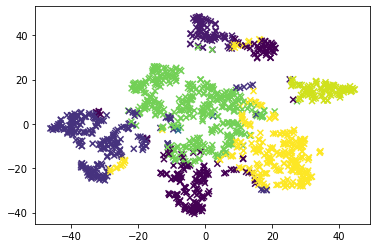

In [59]:
plot(model_spectral, tfidf_corpus_spec_embedding_array, n_components=2)

Hardly 2 clusters are found.

# find k

In [32]:
def find_k():
    ks = [2,5,10,15,20,25,30]
    silhouettes_scores = []
    calinski_harabasz_scores = []
    davies_bouldin_scores = []
    for k in ks:
        X, svd = get_lsa_transformation(20, tfidf_corpus_stopwords)
        model_lsa = SpectralClustering(n_clusters=k)
        fit_model(model_lsa, X)
        score = list(calc_scores(tfidf_corpus_stopwords, model_lsa))

        silhouettes_scores.append(score[0])
        calinski_harabasz_scores.append(score[1])                         
        davies_bouldin_scores.append(score[2])                         

    plot_scores(silhouettes_scores, calinski_harabasz_scores, davies_bouldin_scores, ks)

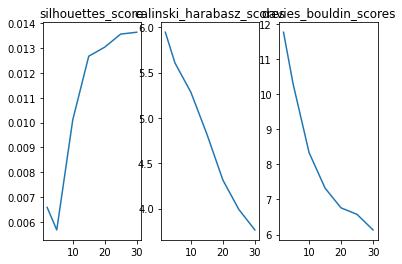

In [33]:
find_k()

calinski gets worse with higher k. But Boulding and silhouette gets better. Maybe k = 20 because silhouette is on a plateau

# Metrics
Metrics provided from sklearn, that don't need true labels:

    metrics.silhouette_score
    metrics.calinski_harabasz_score
    metrics.davies_bouldin_score
    
https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

In [60]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)

scores = []

score = list(calc_scores(tfidf_corpus, model))
score.insert(0, 'normal model')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)
score = list(calc_scores(tfidf_corpus, model_lsa))
score.insert(0, 'model_lsa')
scores.append(score)
score = list(calc_scores(tfidf_corpus_stopwords, model_lsa_stopwords))
score.insert(0, 'model_lsa_stopwords')
scores.append(score)
score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)

scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0                   normal model          0.011531                 4.551881   
1    model with custom stopwords          0.011667                 4.551347   
2                      model_lsa          0.012043                 4.778758   
3            model_lsa_stopwords          0.012800                 4.842215   
4  model with spectral embedding         -0.074069               163.312907   

   davies_bouldin_score  
0              6.697907  
1              6.371018  
2              7.148627  
3              7.219735  
4              1.128462  


scored suggest that spectral clustering works better than kmeans. Very big calinski_harabasz_score  and very small davies_bouldin_score, which is good. But the silhouette score is not good.

In [61]:
scores.to_csv("scores/spectral_clustering.csv")